<a href="https://colab.research.google.com/github/jems2019/AlternusVera/blob/socialCredibility/Social_Credibility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import pandas as pd
import numpy as np
import csv
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
import nltk
import nltk.sentiment
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('wordnet')
import matplotlib.pyplot as plt
from scipy import sparse

#helper libraries to take metrics and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.utils.multiclass import unique_labels
from scipy.spatial.distance import cdist


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [95]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Helper function to print confusion matrix and other stats on each model

def model_stats(y_true, y_pred):
    
    conf_mat = confusion_matrix(y_true, y_pred)
    sns.set(font_scale=1.2)#for label size
    sns.heatmap(conf_mat, annot=True,annot_kws={"size": 16},)# font size

    
    stats = precision_recall_fscore_support(y_true, y_pred, average = 'weighted')
    print('\nprecision')
    print(stats[0])
    print('recall')
    print(stats[1])
    print('f1 score')
    print(stats[2])
    print('\n')
    

In [38]:
url = 'https://raw.githubusercontent.com/jems2019/AlternusVera/socialCredibility/input_data/social_cred/'
data_set = 'train_speaker_with_followers.csv'

data = pd.read_csv(url+data_set)
data.head()


,Unnamed: 0,Unnamed: 0.1,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,twitter_handle,followers
0,0,0,2635.json,FALSE,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer,dwayne_bohac,2116.0
1,1,1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.,ssurovell,5953.0
2,2,2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver,BarackObama,105967791.0
3,4,4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15,9,20,19,2,an interview on CNN,CharlieCrist,31928.0
4,5,5,12465.json,TRUE,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0,3,2,5,1,a an online opinion-piece,repvos,5169.0


# Data Cleaning

In [0]:
class DataCleaning():
  
  # API to convert true, mostly-true and half-true to true
  # false, barely-true and pants-fire to false

  def convertMulticlassToBinaryclass(self, r):
    v = r['label'].lower()
    if (v == 'true'):
      return 1 #'true'
    if (v == 'mostly-true'):
      return 1 #'true'
    if (v == 'half-true'):
      return 1 #'true'
    if (v == 'barely-true'):
      return 0 #'false'
    if (v == 'false'):
      return 0 #'false'
    if (v == 'pants-fire'):
      return 0 #'false'
    
    
  def __init__(self):  
      global data
    # Remove unwanted columns in the dataset
      data = pd.read_csv('https://raw.githubusercontent.com/jems2019/AlternusVera/socialCredibility/input_data/social_cred/train_speaker_with_followers.csv')

      columnsToRemovePar = ['Unnamed: 0', 'Unnamed: 0.1', 'jsonid', 'speaker', 'speakerjobtitle']
      data = data.drop(columns=columnsToRemovePar)
        
    # convert the labels to true and false only
      data['label'] = data.apply(self.convertMulticlassToBinaryclass, axis=1)

      
f= DataCleaning()

In [61]:
data.head()

,label,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,twitter_handle,followers
0,0,Says the Annies List political group supports ...,abortion,Texas,republican,0,1,0,0,0,a mailer,dwayne_bohac,2116.0
1,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Virginia,democrat,0,0,1,1,0,a floor speech.,ssurovell,5953.0
2,1,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Illinois,democrat,70,71,160,163,9,Denver,BarackObama,105967791.0
3,1,The economic turnaround started at the end of ...,"economy,jobs",Florida,democrat,15,9,20,19,2,an interview on CNN,CharlieCrist,31928.0
4,1,The Chicago Bears have had more starting quart...,education,Wisconsin,republican,0,3,2,5,1,a an online opinion-piece,repvos,5169.0


In [0]:
X = data[['barelytruecounts', 'falsecounts', 'halftruecounts', 'mostlytrueocunts', 'pantsonfirecounts', 'followers']]
y = data['label']  # Labels
X_name = ['barelytruecounts', 'falsecounts', 'halftruecounts', 'mostlytrueocunts', 'pantsonfirecounts', 'followers']

# Split data into train and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [0]:
# Below this is where the random forest model is set up and fed the data to classify on
# First training the modle using the data from the split of data above
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [68]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7090909090909091


## Determining Feature Importance

No handles with labels found to put in legend.


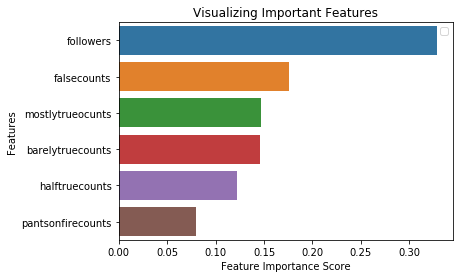

In [70]:
# Looking for feature importance
feature_imp = pd.Series(clf.feature_importances_,index=X_name).sort_values(ascending=False)
feature_imp

sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

No handles with labels found to put in legend.


Average accuracy for Gini criterion: 0.6787878787878792

Feature importance: 
followers            0.322071
falsecounts          0.172694
mostlytrueocunts     0.161881
barelytruecounts     0.136730
halftruecounts       0.122995
pantsonfirecounts    0.083628
dtype: float64


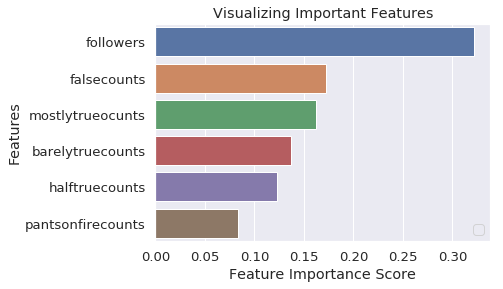


precision
0.6772354312354312
recall
0.6787878787878788
f1 score
0.6759567500687693


cross validation using 5:
[0.72072072 0.63636364 0.72727273 0.65454545 0.67889908]




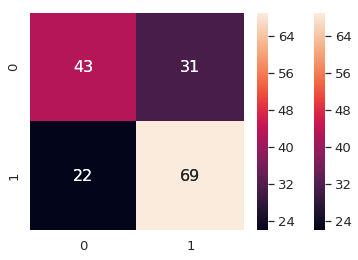

In [77]:
acc = 0
loop = 20
for i in range(loop):
  clf=RandomForestClassifier(n_estimators=100, random_state=10,)
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  acc += metrics.accuracy_score(y_test, y_pred)
  #print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
tot_acc = acc/20
print ("Average accuracy for Gini criterion: " + str(tot_acc) + "\n")

feature_imp = pd.Series(clf.feature_importances_,index=X_name).sort_values(ascending=False)
print ("Feature importance: \n" + str(feature_imp))

sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

conf_mat = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(conf_mat, range(2), range(2))
conf_mat

sns.set(font_scale=1.2)#for label size
sns.heatmap(conf_mat, annot=True,annot_kws={"size": 16})# font size

model_stats(y_test, y_pred)
print ("cross validation using 5:")
print(cross_val_score(clf, X ,y , cv = 5))
print("\n")

In [86]:
# Normalizing data
scaler = StandardScaler()
data['barelytruecounts_norm'] = scaler.fit_transform(data[['barelytruecounts']])
data['falsecounts_norm'] = scaler.fit_transform(data[['falsecounts']])
data['halftruecounts_norm'] = scaler.fit_transform(data[['halftruecounts']])
data['mostlytrueocunts_norm'] = scaler.fit_transform(data[['mostlytrueocunts']])
data['pantsonfirecounts_norm'] = scaler.fit_transform(data[['pantsonfirecounts']])
data['followers_norm'] = scaler.fit_transform(data[['followers']])
data['label_norm'] = scaler.fit_transform(data[['label']])


data_norm = data[['label_norm', 'headline_text', 'subject', 'stateinfo', 'partyaffiliation', 'barelytruecounts_norm', 'falsecounts_norm', 'halftruecounts_norm', 'mostlytrueocunts_norm',
                 'pantsonfirecounts_norm', 'followers_norm']]
data_norm.head()

,label_norm,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,followers_norm
0,-1.220118,Says the Annies List political group supports ...,abortion,Texas,republican,-0.650372,-0.604859,-0.522228,-0.496783,-0.709802,-0.346319
1,0.819593,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Virginia,democrat,-0.650372,-0.654749,-0.499363,-0.474319,-0.709802,-0.346185
2,0.819593,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Illinois,democrat,2.799523,2.887502,3.136111,3.164864,1.180204,3.348144
3,0.819593,The economic turnaround started at the end of ...,"economy,jobs",Florida,democrat,0.088891,-0.205732,-0.064936,-0.069965,-0.289801,-0.345279
4,0.819593,The Chicago Bears have had more starting quart...,education,Wisconsin,republican,-0.650372,-0.505077,-0.476499,-0.384463,-0.499802,-0.346212


In [0]:
# data['correlation_coeff'] = ((data[str(feature_imp.index[0])] * feature_imp[0])**4 + (data[str(feature_imp.index[1])] * feature_imp[1])**3 + (data[str(feature_imp.index[2])] * feature_imp[2])**2 + (data[str(feature_imp.index[3])] * feature_imp[3]))


# Data Cleaning and Text Preprocessing 

*Steps included in the preprocessing:*
- Remove Special Characters and Punctuations
- Lower case the news
- Tokenization
- Remove Stop Words
- Lemmatization
- Stemming 
- Spell Check 

In [0]:
import re

def cleaning(raw_news):
    import nltk
    
    # 1. Remove non-letters/Special Characters and Punctuations
    news = re.sub("[^a-zA-Z]", " ", raw_news)
    
    # 2. Convert to lower case.
    news =  news.lower()
    
    # 3. Tokenize.
    news_words = nltk.word_tokenize( news)
    
    # 4. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 5. Remove stop words. 
    words = [w for w in  news_words  if not w in stops]
    
    # 6. Lemmentize 
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    
    # 7. Stemming
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(stems)

In [92]:
import time
import nltk
nltk.download('punkt')
nltk.download('wordnet')
# clean training and test data 
# create new column "tokenized"
t1 = time.time()

# Add the processed data to the original data. 
# Perhaps using apply function would be more elegant and concise than using for loop
data_norm['clean'] = data_norm["headline_text"].apply(cleaning) 

t2 = time.time()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/Colab Notebooks/GoogleNews-vectors-negative300.bin.gz', binary=True)
words = model.index2word

w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i

WORDS = w_rank

In [0]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [0]:
def spell_checker(text):
    all_words = re.findall(r'\w+', text.lower()) # split sentence to words
    spell_checked_text  = []
    for i in range(len(all_words)):
        spell_checked_text.append(correction(all_words[i]))
    return ' '.join(spell_checked_text)

In [106]:
print("Before: \n", data_norm['clean'][0] )
t1 = time.time()
data_norm['clean'] = data_norm['clean'].apply(spell_checker)
t2 = time.time()
print("\nTime to spell check the train data: \n", len(data_norm), "news:", (t2-t1)/60, "min")

print("\nAfter: \n",data_norm['clean'][0] )
data_norm.head(5)

Before: 
 say anni list polit group support third trimest abort demand

Time to spell check the train data: 
 550 news: 0.27728498379389444 min

After: 
 say anni list polit group support third trimmest abort demand


,label_norm,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,followers_norm,clean
0,-1.220118,Says the Annies List political group supports ...,abortion,Texas,republican,-0.650372,-0.604859,-0.522228,-0.496783,-0.709802,-0.346319,say anni list polit group support third trimme...
1,0.819593,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Virginia,democrat,-0.650372,-0.654749,-0.499363,-0.474319,-0.709802,-0.346185,decline coal start start natur gas took start ...
2,0.819593,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Illinois,democrat,2.799523,2.887502,3.136111,3.164864,1.180204,3.348144,hillary clinton agre john mccain vote give geo...
3,0.819593,The economic turnaround started at the end of ...,"economy,jobs",Florida,democrat,0.088891,-0.205732,-0.064936,-0.069965,-0.289801,-0.345279,econom turnaround start end term
4,0.819593,The Chicago Bears have had more starting quart...,education,Wisconsin,republican,-0.650372,-0.505077,-0.476499,-0.384463,-0.499802,-0.346212,chicago bear start quarterback last year total...


# Sentiment Analysis

In [108]:
# Using sentiment analysis to get sentiment score

senti = nltk.sentiment.vader.SentimentIntensityAnalyzer()

def print_sentiment_scores(sentence):
    snt = senti.polarity_scores(sentence)
    print("{:-<40} \n{}".format(sentence, str(snt)))
    
print_sentiment_scores(data_norm['clean'][0])

say anni list polit group support third trimmest abort demand 
{'neg': 0.123, 'neu': 0.656, 'pos': 0.221, 'compound': 0.296}


In [0]:
def get_vader_polarity(snt):
    if not snt:
        return None
    elif snt['neg'] > snt['pos'] and snt['neg'] > snt['neu']:
        return -1
    elif snt['pos'] > snt['neg'] and snt['pos'] > snt['neu']:
        return 1
    else:
        return 0

In [0]:
#Function to determine if a text is negative(-1) or postive (1) or neutral (0)
def get_polarity_type(sentence):
    sentimentVector = []
    snt = senti.polarity_scores(sentence)
    sentimentVector.append(get_vader_polarity(snt))
    sentimentVector.append(snt['neg'])
    sentimentVector.append(snt['neu'])
    sentimentVector.append(snt['pos'])
    sentimentVector.append(snt['compound'])
    
    print(sentimentVector)
    return sentimentVector

In [111]:
sentiment = []
vader_pol = []
cmp_score = []
for row in data_norm['clean']:
    get_pols = get_polarity_type(row)
    sentiment.append(get_pols[1:])
    vader_pol.append(get_pols[0])
    cmp_score.append(get_pols[1:][-1]) #last element 
    
data_norm['sentiment_vector'] = sentiment
data_norm['vader_polarity'] = vader_pol
data_norm['sentiment_score'] = cmp_score


[0, 0.123, 0.656, 0.221, 0.296]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.161, 0.645, 0.194, 0.128]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.335, 0.6, 0.065, -0.7506]
[0, 0.085, 0.915, 0.0, -0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.153, 0.657, 0.19, 0.128]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.198, 0.802, 0.0, -0.4939]
[0, 0.0, 0.543, 0.457, 0.6369]
[0, 0.0, 1.0, 0.0, 0.0]
[-1, 0.507, 0.493, 0.0, -0.802]
[0, 0.0, 0.859, 0.141, 0.2411]
[0, 0.238, 0.495, 0.267, 0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.199, 0.588, 0.213, 0.0516]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.184, 0.702, 0.114, -0.2033]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.333, 0.667, 0.0, -0.6124]
[0, 0.0, 0.735, 0.265, 0.5574]
[0, 0.415, 0.585, 0.0, -0.8316]
[0, 0.087, 0.73, 0.183, 0.2924]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.116, 0.884, 0.0, -0.2732]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]


In [112]:
data_norm.head(5)

,label_norm,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,followers_norm,clean,sentiment_vector,vader_polarity,sentiment_score
0,-1.220118,Says the Annies List political group supports ...,abortion,Texas,republican,-0.650372,-0.604859,-0.522228,-0.496783,-0.709802,-0.346319,say anni list polit group support third trimme...,"[0.123, 0.656, 0.221, 0.296]",0,0.2960
1,0.819593,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Virginia,democrat,-0.650372,-0.654749,-0.499363,-0.474319,-0.709802,-0.346185,decline coal start start natur gas took start ...,"[0.0, 1.0, 0.0, 0.0]",0,0.0000
2,0.819593,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Illinois,democrat,2.799523,2.887502,3.136111,3.164864,1.180204,3.348144,hillary clinton agre john mccain vote give geo...,"[0.161, 0.645, 0.194, 0.128]",0,0.1280
3,0.819593,The economic turnaround started at the end of ...,"economy,jobs",Florida,democrat,0.088891,-0.205732,-0.064936,-0.069965,-0.289801,-0.345279,econom turnaround start end term,"[0.0, 1.0, 0.0, 0.0]",0,0.0000
4,0.819593,The Chicago Bears have had more starting quart...,education,Wisconsin,republican,-0.650372,-0.505077,-0.476499,-0.384463,-0.499802,-0.346212,chicago bear start quarterback last year total...,"[0.335, 0.6, 0.065, -0.7506]",0,-0.7506


# Topic Modeling

In [124]:
data_norm['index'] = data_norm.index
train_lda = data_norm[['clean', 'index']]
train_lda.head(4)

,clean,index
0,say anni list polit group support third trimme...,0
1,decline coal start start natur gas took start ...,1
2,hillary clinton agre john mccain vote give geo...,2
3,econom turnaround start end term,3


In [125]:
processed_docs = train_lda['clean'].map(lambda doc: doc.split(" "))
processed_docs[:4]

0    [say, anni, list, polit, group, support, third...
1    [decline, coal, start, start, natur, gas, took...
2    [hillary, clinton, agre, john, mccain, vote, g...
3               [econom, turnaround, start, end, term]
Name: clean, dtype: object

In [0]:
def update_lda_results_to_dataset(dataframe,topiccolnames,coltoapplylda,colnamedictionary,colnameldamodel, colnameldatopwords):
    dataframe[topiccolnames] = dataframe.apply(
    lambda row: identify_topic_number_score_label_topwords(
        row[coltoapplylda],colnamedictionary,colnameldamodel,
        colnameldatopwords), axis=1)
    return dataframe

In [0]:
def get_dictionary_print_words(dataframe,colname):
    dictionary_gensim = gensim.corpora.Dictionary(processed_docs)
    count = 0
    print('######## DICTIONARY Words and occurences ########')
    for k, v in dictionary_gensim.iteritems():
        print(k, v)
        count += 1
        if count > 10:
            break
    dictionary_gensim.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    return dictionary_gensim, tokenized_docs_local

In [0]:
def get_word_tokens(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) > 3:
            result.append(token)
    return result
tokenized_docs_local = data_norm['clean'].map(get_word_tokens)

In [0]:
def get_bow_corpus_print_sample(dataframe,colname):
    dictionary_gensim, tokenized_docs_local = get_dictionary_print_words(dataframe, colname)
    bow_corpus_local = [dictionary_gensim.doc2bow(doc) for doc in tokenized_docs_local]
    bow_doc_local_0 = bow_corpus_local[0]
    print('\n ######## BOW VECTOR FIRST ITEM ########')
    print(bow_doc_local_0)
    print('\n ######## PREVIEW BOW ########')
    for i in range(len(bow_doc_local_0)):
        print("Word {} (\"{}\") appears {} time.".format(bow_doc_local_0[i][0], 
                                               dictionary_gensim[bow_doc_local_0[i][0]], bow_doc_local_0[i][1]))
    return bow_corpus_local, dictionary_gensim

In [130]:
bow_corpus_headline, dictionary_headline = get_bow_corpus_print_sample(data_norm,'clean')

######## DICTIONARY Words and occurences ########
0 abort
1 anni
2 demand
3 group
4 list
5 polit
6 say
7 support
8 third
9 trimmest
10 administr

 ######## BOW VECTOR FIRST ITEM ########
[(1, 1)]

 ######## PREVIEW BOW ########
Word 1 ("support") appears 1 time.


In [0]:
def get_lda_model_topics_topwords_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2, random_state=1)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=10,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model,lda_topics_words

In [134]:
lda_model_headline, lda_headline_topic_words = get_lda_model_topics_topwords_print_top_topics(
    bow_corpus_headline, 10 ,dictionary_headline)

0::['care', 'health', 'would', 'bill', 'obama', 'time', 'presid', 'barack', 'country', 'vote']
1::['debt', 'school', 'govern', 'peopl', 'rate', 'state', 'percent', 'time', 'first', 'obama']
2::['rais', 'feder', 'last', 'governor', 'fund', 'state', 'bill', 'republican', 'percent', 'every']
3::['year', 'state', 'last', 'american', 'unit', 'would', 'cost', 'first', 'presid', 'money']
4::['percent', 'american', 'said', 'state', 'sinc', 'make', 'would', 'text', 'country', 'obama']
5::['million', 'immigra', 'every', 'vote', 'make', 'work', 'year', 'feder', 'peopl', 'fund']
6::['time', 'creat', 'last', 'year', 'would', 'state', 'first', 'text', 'sinc', 'money']
7::['percent', 'nation', 'right', 'country', 'increas', 'pass', 'presid', 'peopl', 'last', 'bill']
8::['vote', 'republican', 'support', 'country', 'state', 'budget', 'spend', 'health', 'percent', 'text']
9::['presid', 'obama', 'took', 'barack', 'million', 'fund', 'state', 'peopl', 'sinc', 'health']


In [0]:
def identify_topic_number_score_label_topwords(text,dictionary_local,lda_model_local,lda_topics_top_words_local):
    bow_vector_local = dictionary_local.doc2bow(get_word_tokens(text))
    topic_number_local, topic_score_local = sorted(
        lda_model_local[bow_vector_local], key=lambda tup: -1*tup[1])[0]
    #print (topic_number_local, topic_score_local)
    return pd.Series([topic_number_local, topic_score_local," ".join(lda_topics_top_words_local[int(topic_number_local)][1])])

In [137]:
headlinetopiccolnames = ['topic_number','lda_score','topic_top_words']
data_norm = update_lda_results_to_dataset(
    data_norm, headlinetopiccolnames,'clean', dictionary_headline, lda_model_headline, lda_headline_topic_words)
data_norm.head()

,label_norm,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,followers_norm,clean,sentiment_vector,vader_polarity,sentiment_score,index,topic_number,lda_score,topic_top_words
0,-1.220118,Says the Annies List political group supports ...,abortion,Texas,republican,-0.650372,-0.604859,-0.522228,-0.496783,-0.709802,-0.346319,say anni list polit group support third trimme...,"[0.123, 0.656, 0.221, 0.296]",0,0.2960,0,8,0.549984,vote republican support country state budget s...
1,0.819593,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Virginia,democrat,-0.650372,-0.654749,-0.499363,-0.474319,-0.709802,-0.346185,decline coal start start natur gas took start ...,"[0.0, 1.0, 0.0, 0.0]",0,0.0000,1,9,0.699992,presid obama took barack million fund state pe...
2,0.819593,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Illinois,democrat,2.799523,2.887502,3.136111,3.164864,1.180204,3.348144,hillary clinton agre john mccain vote give geo...,"[0.161, 0.645, 0.194, 0.128]",0,0.1280,2,8,0.549973,vote republican support country state budget s...
3,0.819593,The economic turnaround started at the end of ...,"economy,jobs",Florida,democrat,0.088891,-0.205732,-0.064936,-0.069965,-0.289801,-0.345279,econom turnaround start end term,"[0.0, 1.0, 0.0, 0.0]",0,0.0000,3,0,0.100000,care health would bill obama time presid barac...
4,0.819593,The Chicago Bears have had more starting quart...,education,Wisconsin,republican,-0.650372,-0.505077,-0.476499,-0.384463,-0.499802,-0.346212,chicago bear start quarterback last year total...,"[0.335, 0.6, 0.065, -0.7506]",0,-0.7506,4,3,0.774984,year state last american unit would cost first...
